<img src="../images/logos/xradar_logo.svg" width=250 alt="xradar"></img>

# Xradar Basics


---

## Overview

1. Xradar general overview
1. Radar data IO
2. Radar data georeferencing
3. Data visualization
   

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary |  Basic features |
| [Radar Cookbook](https://projectpythia.org/radar-cookbook/README.html) | Necessary |  Radar basics |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary |  Plotting basic features |
- **Time to learn**: 30 minutes
---

## Imports

In [1]:
import xradar as xd
import pyart
import wradlib as wrl

import fsspec
import numpy as np
from xarray.backends.api import open_datatree

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Xradar

`Xradar` is a `Python` package developed to streamline the **reading** and **writing** of radar data across various formats, with exports aligned to standards like ODIM_H5 and CfRadial. Born from the **Open Radar Science Community's** collaboration at **ERAD2022**, `Xradar` uses an `xarray-based` data model, compatible with the upcoming **CfRadial2.1/FM301** standard. This ensures seamless integration with other xarray-based software and existing open-source radar processing tools.

### Xradar data model
Xradar leverages the upcoming FM301 standard, a subset of CfRadial2.0, using Xarray to efficiently manage radar data.

#### DataTree Structure (CfRadial2.1/FM301 standard)
Xradar employs `xarray.DataTree` objects to organize radar sweeps within a single structure, where each sweep is an `xarray.Dataset` containing relevant metadata and variables.

<img src="../images/CfRadial2.1.svg" width=500 alt="xradar"></img>

## Xradar importers

Xradar supports several importers to handle different radar data formats. These importers typically include:

- **ODIM_H5**: For reading radar data in the ODIM_H5 format, which is widely used in Europe and supported by the EUMETNET OPERA program.

- **CfRadial**: For importing data in the CfRadial format, which is commonly used in the atmospheric sciences community.

- **SIGMET/IRIS**: For ingesting radar data from SIGMET/IRIS formats, which are used by various weather radar systems globally.

- **GAMIC**: For reading data from GAMIC radars, which use their proprietary format.

For more importers check [here](https://docs.openradarscience.org/projects/xradar/en/stable/importers.html)

Let's find some Italian radar data located at the Erad 2024 Bucket

In [2]:
# Set the URL and path for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = f"pythia/radar/erad2024"

fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

fs.glob(f"{path}/*")

['pythia/radar/erad2024/.DS_Store',
 'pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia',
 'pythia/radar/erad2024/baltrad',
 'pythia/radar/erad2024/dda_data',
 'pythia/radar/erad2024/gpm_api',
 'pythia/radar/erad2024/lrose',
 'pythia/radar/erad2024/wradlib',
 'pythia/radar/erad2024/zarr_radar']

In [3]:
files = fs.glob(
    "pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/*.nc"
)
files[:3]

['pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1300.nc',
 'pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1305.nc',
 'pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1310.nc']

In [4]:
radar_files = [f"s3://{i}" for i in files]
radar_files[:3]

['s3://pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1300.nc',
 's3://pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1305.nc',
 's3://pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1310.nc']

In [5]:
local_files = [
    fsspec.open_local(
        f"simplecache::{URL}{i}", s3={"anon": True}, filecache={"cache_storage": "."}
    )
    for i in files
]

We can open one of this `nc` files using `xradar.io.open_cfradial1_datree` method

In [6]:
# with fs.open(radar_files[0], mode="rb", anon=True, client_kwargs=dict(endpoint_url=URL)) as file:
#     dtree = xd.io.open_cfradial1_datatree(file)

In [7]:
dt = xd.io.open_cfradial1_datatree(local_files[0])
display(dt)

DataTree('root', parent=None)
│   Dimensions:              (sweep: 8, frequency: 1)
│   Coordinates:
│     * frequency            (frequency) float32 4B 9.339e+09
│   Dimensions without coordinates: sweep
│   Data variables: (12/13)
│       sweep_fixed_angle    (sweep) float32 32B ...
│       sweep_group_name     (sweep) <U9 288B 'sweep_0.0' ... 'sweep_7.0'
│       volume_number        float64 8B ...
│       platform_type        |S32 32B ...
│       primary_axis         |S32 32B ...
│       status_str           |S1 1B ...
│       ...                   ...
│       time_coverage_start  |S32 32B ...
│       time_coverage_end    |S32 32B ...
│       latitude             float64 8B ...
│       longitude            float64 8B ...
│       altitude             float64 8B ...
│       altitude_agl         float64 8B ...
│   Attributes: (12/14)
│       Conventions:         CF-1.7
│       version:             CF-Radial-1.4
│       title:               VOL_A
│       institution:         
│       references:          Conversion software: Radx::SigmetRadxFile
│       source:              Sigmet IRIS software
│       ...                  ...
│       site_name:           Desio_Radar
│       scan_name:           VOL_A
│       scan_id:             0
│       platform_is_mobile:  false
│       ray_times_increase:  true
│       history:             Wed May 22 13:32:05 2024: ncap2 -Os fixed_angle  (:)...
├── DataTree('radar_parameters')
│       Dimensions:                   ()
│       Data variables:
│           radar_antenna_gain_v      float32 4B ...
│           radar_receiver_bandwidth  float32 4B ...
│           radar_beam_width_v        float32 4B ...
│           radar_beam_width_h        float32 4B ...
│           radar_antenna_gain_h      float32 4B ...
├── DataTree('radar_calibration')
│       Dimensions:                   ()
│       Data variables: (12/55)
│           time                      |S32 32B ...
│           pulse_width               timedelta64[ns] 8B ...
│           xmit_power_h              float32 4B ...
│           xmit_power_v              float32 4B ...
│           two_way_waveguide_loss_h  float32 4B ...
│           two_way_waveguide_loss_v  float32 4B ...
│           ...                        ...
│           zdr_correction            float32 4B ...
│           ldr_correction_h          float32 4B ...
│           ldr_correction_v          float32 4B ...
│           system_phidp              float32 4B ...
│           test_power_h              float32 4B ...
│           test_power_v              float32 4B ...
├── DataTree('georeferencing_correction')
├── DataTree('sweep_0')
│       Dimensions:                    (azimuth: 360, range: 416)
│       Coordinates:
│           time                       (azimuth, range) datetime64[ns] 1MB 2024-05-22...
│         * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
│         * azimuth                    (azimuth) float32 1kB 0.01923 1.027 ... 359.1
│           elevation                  (azimuth) float32 1kB ...
│           latitude                   float64 8B ...
│           longitude                  float64 8B ...
│           altitude                   float64 8B ...
│       Data variables: (12/30)
│           sweep_fixed_angle          float32 4B ...
│           sweep_number               float64 8B ...
│           sweep_mode                 <U20 80B 'azimuth_surveillance'
│           prt_mode                   |S32 32B ...
│           follow_mode                |S32 32B ...
│           ray_n_gates                (azimuth) float64 3kB ...
│           ...                         ...
│           RHOHV                      (azimuth, range) float32 599kB nan 0.328 ... nan
│           DBZ                        (azimuth, range) float32 599kB nan nan ... nan
│           MCSSX                      (azimuth, range) float32 599kB nan nan ... nan
│           ZDR                        (azimuth, range) float32 599kB nan -3.19 ... nan
│           KDP              

In this `Xarray.Datatree` object, the first two nodes contains radar metadata and the others contains `Xarray.Datasets` for each sweeps. 

In [8]:
for sweep in dt.children:
    try:
        print(
            f"{sweep} - elevation {np.round(dt[sweep]['sweep_fixed_angle'].values[...], 1)}"
        )
    except KeyError:
        print(sweep)

radar_parameters
radar_calibration
georeferencing_correction
sweep_0 - elevation 0.699999988079071
sweep_1 - elevation 1.2999999523162842
sweep_2 - elevation 3.0
sweep_3 - elevation 5.0
sweep_4 - elevation 7.0
sweep_5 - elevation 10.0
sweep_6 - elevation 15.0
sweep_7 - elevation 25.0


Let's explore the `1.0` degrees elevation ('sweep_2')

In [9]:
ds_sw2 = dt["sweep_2"].ds
display(ds_sw2)

<xarray.DatasetView> Size: 7MB
Dimensions:                    (azimuth: 360, range: 416)
Coordinates:
    time                       (azimuth, range) datetime64[ns] 1MB 2024-05-22...
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * azimuth                    (azimuth) float32 1kB 0.05219 1.005 ... 359.0
    elevation                  (azimuth) float32 1kB ...
    latitude                   float64 8B ...
    longitude                  float64 8B ...
    altitude                   float64 8B ...
Data variables: (12/30)
    sweep_fixed_angle          float32 4B 3.0
    sweep_number               float64 8B ...
    sweep_mode                 <U20 80B 'azimuth_surveillance'
    prt_mode                   |S32 32B ...
    follow_mode                |S32 32B ...
    ray_n_gates                (azimuth) float64 3kB ...
    ...                         ...
    RHOHV                      (azimuth, range) float32 599kB nan 0.7706 ... nan
    DBZ                        (azimuth, range) float32 599kB nan nan ... nan
    MCSSX                      (azimuth, range) float32 599kB nan 1.0 ... nan
    ZDR                        (azimuth, range) float32 599kB nan 0.63 ... nan
    KDP                        (azimuth, range) float32 599kB nan 0.0 ... nan
    WIDTH                      (azimuth, range) float32 599kB nan nan ... nan

## Xradar visualization

We can make a plot using [`xarray.plot`](https://docs.xarray.dev/en/latest/user-guide/plotting.html) functionality.

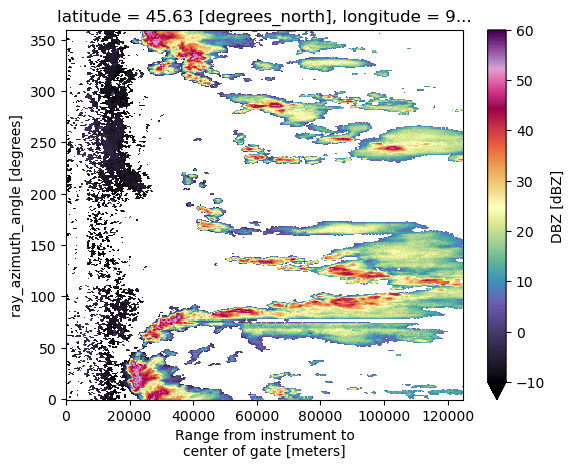

In [11]:
ds_sw2.DBZ.plot(
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

The radar data in the `Xarray.Dataset` object includes range and azimuth as coordinates. To create a radial plot, apply the [`xradar.georeference`](https://docs.openradarscience.org/projects/xradar/en/stable/georeference.html) method. This method will generate x, y, and z coordinates for the plot.

In [12]:
ds_sw2 = ds_sw2.xradar.georeference()
display(ds_sw2)

<xarray.Dataset> Size: 11MB
Dimensions:                    (azimuth: 360, range: 416)
Coordinates:
    time                       (azimuth, range) datetime64[ns] 1MB 2024-05-22...
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * azimuth                    (azimuth) float32 1kB 0.05219 1.005 ... 359.0
    elevation                  (azimuth) float32 1kB 2.999 2.999 ... 2.999 2.999
    latitude                   float64 8B 45.63
    longitude                  float64 8B 9.196
    altitude                   float64 8B 241.0
    crs_wkt                    int64 8B 0
    x                          (azimuth, range) float64 1MB 0.1364 ... -2.075...
    y                          (azimuth, range) float64 1MB 149.8 ... 1.244e+05
    z                          (azimuth, range) float64 1MB 248.8 ... 7.675e+03
Data variables: (12/30)
    sweep_fixed_angle          float32 4B 3.0
    sweep_number               float64 8B ...
    sweep_mode                 <U20 80B 'azimuth_surveillance'
    prt_mode                   |S32 32B ...
    follow_mode                |S32 32B ...
    ray_n_gates                (azimuth) float64 3kB ...
    ...                         ...
    RHOHV                      (azimuth, range) float32 599kB nan 0.7706 ... nan
    DBZ                        (azimuth, range) float32 599kB nan nan ... nan
    MCSSX                      (azimuth, range) float32 599kB nan 1.0 ... nan
    ZDR                        (azimuth, range) float32 599kB nan 0.63 ... nan
    KDP                        (azimuth, range) float32 599kB nan 0.0 ... nan
    WIDTH                      (azimuth, range) float32 599kB nan nan ... nan

We can now create a radial plot passing `x` and `y` coordinates

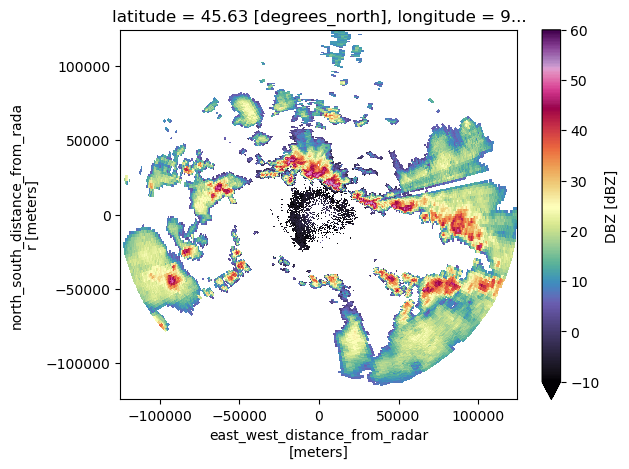

In [13]:
ds_sw2.DBZ.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

## Data slicing

We can use the power of `Xarray` to acces data within the first 50 kilometers by [slicing](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#slicing-along-coordinates) along coordinates.

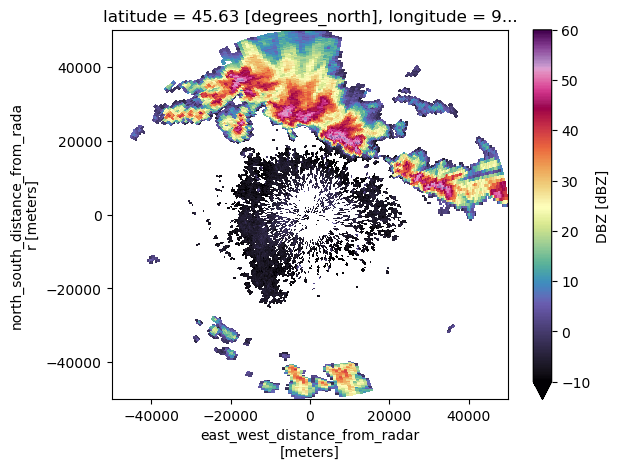

In [14]:
ds_sw2.sel(range=slice(0, 5e4)).DBZ.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

Let's suposse we want to subset between 90 and 180 degrees angle in azumith

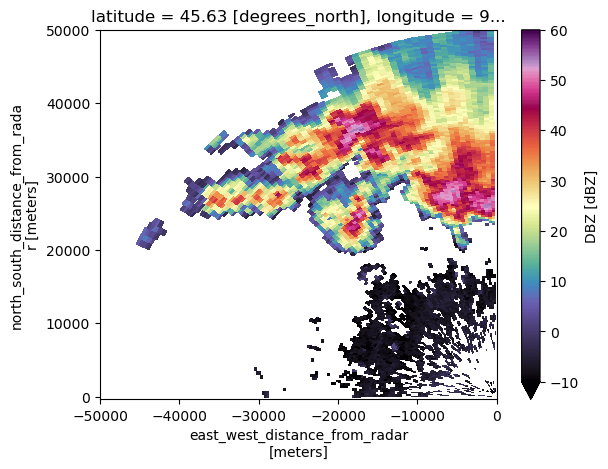

In [16]:
ds_sw2.sel(azimuth=slice(270, 360), range=slice(0, 5e4)).DBZ.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

Perhaps, we just what to see radar reflectivity along the 100 degrees angle in azimuth

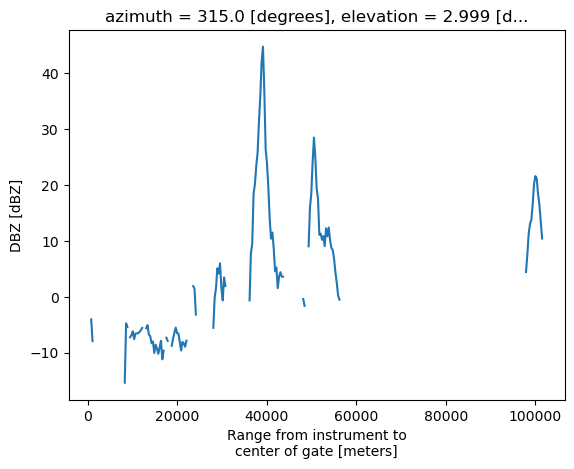

In [20]:
ds_sw2.sel(azimuth=315, method="nearest").DBZ.plot()

## Xradar integration

### Py-Art

`Xradar` datatree objects can be ported to `Py-ART` radar objects using the pyart.xradar.Xradar method.

In [832]:
"""
Utilities for interfacing between xradar and Py-ART

"""


import copy

import numpy as np
import pandas as pd
from datatree import DataTree, formatting, formatting_html
from datatree.treenode import NodePath
from xarray import DataArray, Dataset, concat
from xarray.core import utils
from xradar.util import get_sweep_keys

from pyart.config import get_metadata
from pyart.core.transforms import (
    antenna_vectors_to_cartesian,
    cartesian_to_geographic,
    cartesian_vectors_to_geographic,
)
from pyart.lazydict import LazyLoadDict


class Xgrid:
    def __init__(self, grid_ds):
        """
        Wraps a Cf-compliant xarray Dataset into a PyART Grid Object.
        Note that the times must not be decoded by xr.open_dataset when loading the file.

        Parameters
        ----------
        grid_ds: xarray Dataset
            The xarray Dataset to convert to a Py-ART grid.
        """
        if "units" not in list(grid_ds["time"].attrs.keys()):
            raise RuntimeError(
                "decode_times must be set to false when opening grid file!"
            )
        self.ds = grid_ds
        self.time = dict(data=np.atleast_1d(self.ds["time"].values))
        self.time.update(self.ds["time"].attrs)
        self.fields = {}
        self._find_fields()
        self.origin_altitude = dict(
            data=np.atleast_1d(self.ds["origin_altitude"].values)
        )
        self.origin_altitude.update(self.ds["origin_altitude"].attrs)
        self.origin_latitude = dict(
            data=np.atleast_1d(self.ds["origin_latitude"].values)
        )
        self.origin_latitude.update(self.ds["origin_latitude"].attrs)
        self.origin_longitude = dict(
            data=np.atleast_1d(self.ds["origin_longitude"].values)
        )
        self.origin_longitude.update(self.ds["origin_longitude"].attrs)
        self.z = dict(data=np.atleast_1d(self.ds["z"].values))
        self.z.update(self.ds["z"].attrs)
        self.y = dict(data=np.atleast_1d(self.ds["y"].values))
        self.y.update(self.ds["y"].attrs)
        self.x = dict(data=np.atleast_1d(self.ds["x"].values))
        self.x.update(self.ds["x"].attrs)
        self.nradar = len(self.ds["nradar"].values)
        self.radar_altitude = dict(data=np.atleast_1d(self.ds["radar_altitude"].values))
        self.radar_altitude.update(self.ds["radar_altitude"].attrs)
        self.radar_longitude = dict(
            data=np.atleast_1d(self.ds["radar_longitude"].values)
        )
        self.radar_longitude.update(self.ds["radar_longitude"].attrs)
        self.radar_latitude = dict(data=np.atleast_1d(self.ds["radar_latitude"].values))
        self.radar_latitude.update(self.ds["radar_latitude"].attrs)
        self.radar_time = dict(data=np.atleast_1d(self.ds["radar_time"].values))
        self.radar_time.update(self.ds["radar_time"].attrs)
        self.radar_name = dict(data=self.ds["radar_name"].values.astype("<U12"))
        self.radar_name.update(self.ds["radar_name"].attrs)
        self.projection = self.ds["projection"].attrs
        if "_include_lon_0_lat_0" in list(self.projection.keys()):
            if self.projection["_include_lon_0_lat_0"].lower() == "true":
                self.projection["_include_lon_0_lat_0"] = True
            else:
                self.projection["_include_lon_0_lat_0"] = False

        self.init_point_altitude()
        self.init_point_longitude_latitude()
        self.init_point_x_y_z()

    def _find_fields(self):
        for key in list(self.ds.variables.keys()):
            if self.ds[key].dims == ("time", "z", "y", "x"):
                self.fields[key] = {}
                self.fields[key]["data"] = self.ds[key].values.squeeze()
                self.fields[key].update(self.ds[key].attrs)

    def get_projparams(self):
        projparams = self.projection.copy()
        if projparams.pop("_include_lon_0_lat_0", False):
            projparams["lon_0"] = self.origin_longitude["data"][0]
            projparams["lat_0"] = self.origin_latitude["data"][0]
        return projparams

    @property
    def metadata(self):
        return self.ds.attrs

    @property
    def ny(self):
        return self.ds.sizes["y"]

    @property
    def nx(self):
        return self.ds.sizes["x"]

    @property
    def nz(self):
        return self.ds.sizes["z"]

    # Attribute init/reset methods
    def init_point_x_y_z(self):
        """Initialize or reset the point_{x, y, z} attributes."""
        self.point_x = LazyLoadDict(get_metadata("point_x"))
        self.point_x.set_lazy("data", _point_data_factory(self, "x"))

        self.point_y = LazyLoadDict(get_metadata("point_y"))
        self.point_y.set_lazy("data", _point_data_factory(self, "y"))

        self.point_z = LazyLoadDict(get_metadata("point_z"))
        self.point_z.set_lazy("data", _point_data_factory(self, "z"))

    def init_point_longitude_latitude(self):
        """
        Initialize or reset the point_{longitude, latitudes} attributes.
        """
        point_longitude = LazyLoadDict(get_metadata("point_longitude"))
        point_longitude.set_lazy("data", _point_lon_lat_data_factory(self, 0))
        self.point_longitude = point_longitude

        point_latitude = LazyLoadDict(get_metadata("point_latitude"))
        point_latitude.set_lazy("data", _point_lon_lat_data_factory(self, 1))
        self.point_latitude = point_latitude

    def init_point_altitude(self):
        """Initialize the point_altitude attribute."""
        point_altitude = LazyLoadDict(get_metadata("point_altitude"))
        point_altitude.set_lazy("data", _point_altitude_data_factory(self))
        self.point_altitude = point_altitude

    def get_point_longitude_latitude(self, level=0, edges=False):
        """
        Return arrays of longitude and latitude for a given grid height level.

        Parameters
        ----------
        level : int, optional
            Grid height level at which to determine latitudes and longitudes.
            This is not currently used as all height level have the same
            layout.
        edges : bool, optional
            True to calculate the latitude and longitudes of the edges by
            interpolating between Cartesian coordinates points and
            extrapolating at the boundaries. False to calculate the locations
            at the centers.

        Returns
        -------
        longitude, latitude : 2D array
            Arrays containing the latitude and longitudes, in degrees, of the
            grid points or edges between grid points for the given height.

        """
        x = self.x["data"]
        y = self.y["data"]
        projparams = self.get_projparams()
        return cartesian_vectors_to_geographic(x, y, projparams, edges=edges)

    def add_field(self, field_name, dic, replace_existing=False):
        """
        Add a field to the object.

        Parameters
        ----------
        field_name : str
            Name of the field to add to the dictionary of fields.
        dic : dict
            Dictionary contain field data and metadata.
        replace_existing : bool, optional
            True to replace the existing field with key field_name if it
            exists, loosing any existing data. False will raise a ValueError
            when the field already exists.

        """
        # check that the field dictionary to add is valid
        if field_name in self.fields and replace_existing is False:
            err = f"A field with name: {field_name} already exists"
            raise ValueError(err)
        if "data" not in dic:
            raise KeyError("dic must contain a 'data' key")
        if dic["data"].shape != (self.nz, self.ny, self.nx):
            t = (self.nz, self.ny, self.nx)
            err = "'data' has invalid shape, should be (%i, %i)" % t
            raise ValueError(err)
        self.fields[field_name] = dic

    def to_xarray(self):
        """
        Convert the Grid object to an xarray format.

        Attributes
        ----------
        time : dict
            Time of the grid.
        fields : dict of dicts
            Moments from radars or other variables.
        longitude, latitude : dict, 2D
            Arrays of latitude and longitude for the grid height level.
        x, y, z : dict, 1D
            Distance from the grid origin for each Cartesian coordinate axis
            in a one dimensional array.

        """

        lon, lat = self.get_point_longitude_latitude()
        z = self.z["data"]
        y = self.y["data"]
        x = self.x["data"]

        time = self.ds.time.values

        ds = Dataset()
        for field in list(self.fields.keys()):
            field_data = self.fields[field]["data"]
            data = DataArray(
                np.expand_dims(field_data, 0),
                dims=("time", "z", "y", "x"),
                coords={
                    "time": (["time"], time),
                    "z": (["z"], z),
                    "lat": (["y", "x"], lat),
                    "lon": (["y", "x"], lon),
                    "y": (["y"], y),
                    "x": (["x"], x),
                },
            )
            for meta in list(self.fields[field].keys()):
                if meta != "data":
                    data.attrs.update({meta: self.fields[field][meta]})

            ds[field] = data
            ds.lon.attrs = [
                ("long_name", "longitude of grid cell center"),
                ("units", "degree_E"),
                ("standard_name", "Longitude"),
            ]
            ds.lat.attrs = [
                ("long_name", "latitude of grid cell center"),
                ("units", "degree_N"),
                ("standard_name", "Latitude"),
            ]

            ds.z.attrs = get_metadata("z")
            ds.y.attrs = get_metadata("y")
            ds.x.attrs = get_metadata("x")

            ds.z.encoding["_FillValue"] = None
            ds.lat.encoding["_FillValue"] = None
            ds.lon.encoding["_FillValue"] = None
            ds.close()
        return ds


class Xradar:
    def __init__(self, xradar, default_sweep="sweep_0", scan_type=None):
        self.xradar = xradar
        self.scan_type = scan_type or "ppi"
        self.sweep_group_names = get_sweep_keys(self.xradar)
        self.nsweeps = len(self.sweep_group_names)
        self.combined_sweeps = self._combine_sweeps()
        self.fields = self._find_fields(self.combined_sweeps)

        # Check to see if the time is multidimensional - if it is, collapse it
        if len(self.combined_sweeps.time.dims) > 1:
            time = self.combined_sweeps.time.isel(range=0)
        else:
            time = self.combined_sweeps.time
        self.time = dict(
            data=(time - time.min()).astype(
                "int64"
            ).values
            / 1e9,
            units=f"seconds since {pd.to_datetime(self.combined_sweeps.time.min().values).strftime('%Y-%m-%d %H:%M:%S.0')}",
            calendar="gregorian",
        )
        self.range = dict(data=self.combined_sweeps.range.values)
        self.azimuth = dict(data=self.combined_sweeps.azimuth.values)
        self.elevation = dict(data=self.combined_sweeps.elevation.values)
        # Check to see if the time is multidimensional - if it is, collapse it
        if len(self.combined_sweeps.sweep_fixed_angle.dims) > 1:
            self.combined_sweeps["sweep_fixed_angle"] = ("sweep_number",np.unique(radar.combined_sweeps.sweep_fixed_angle))
        self.fixed_angle = dict(data=self.combined_sweeps.sweep_fixed_angle.values)
        self.antenna_transition = None
        self.latitude = dict(
            data=np.expand_dims(self.xradar["latitude"].values, axis=0)
        )
        self.longitude = dict(
            data=np.expand_dims(self.xradar["longitude"].values, axis=0)
        )
        self.altitude = dict(
            data=np.expand_dims(self.xradar["altitude"].values, axis=0)
        )
        self.sweep_end_ray_index = dict(
            data=self.combined_sweeps.ngates.groupby("sweep_number").max().values
        )
        self.sweep_start_ray_index = dict(
            data=self.combined_sweeps.ngates.groupby("sweep_number").min().values
        )
        self.metadata = dict(**self.xradar.attrs)
        self.ngates = len(self.range["data"])
        self.nrays = len(self.azimuth["data"])
        self.instrument_parameters = self.find_instrument_parameters()
        self.init_gate_x_y_z()
        self.init_gate_alt()

    def __repr__(self):
        return formatting.datatree_repr(self.xradar)

    def _repr_html_(self):
        return formatting_html.datatree_repr(self.xradar)

    def __getitem__(self: DataTree, key):
        """
        Access child nodes, variables, or coordinates stored anywhere in this tree.

        Returned object will be either a DataTree or DataArray object depending on whether the key given points to a
        child or variable.

        Parameters
        ----------
        key : str
            Name of variable / child within this node, or unix-like path to variable / child within another node.

        Returns
        -------
        Union[DataTree, DataArray]
        """

        # Either:
        if utils.is_dict_like(key):
            # dict-like indexing
            raise NotImplementedError("Should this index over whole tree?")
        elif isinstance(key, str):
            # path-like: a name of a node/variable, or path to a node/variable
            path = NodePath(key)
            return self.xradar._get_item(path)
        elif utils.is_list_like(key):
            # iterable of variable names
            raise NotImplementedError(
                "Selecting via tags is deprecated, and selecting multiple items should be "
                "implemented via .subset"
            )
        else:
            raise ValueError(f"Invalid format for key: {key}")

        # Iterators

    def find_instrument_parameters(self):
        # By default, check the radar_parameters first
        if "radar_parameters" in list(self.xradar.children):
            radar_param_dict = self.xradar["radar_parameters"].ds.to_dict(data="array")
            instrument_parameters = radar_param_dict["data_vars"]
            instrument_parameters.update(radar_param_dict["attrs"])

        else:
            instrument_parameters = {}

        # Check to see if the root dataset has this info
        if len(self.xradar.ds) > 0:
            root_param_dict = self.xradar.ds.to_dict(data="array")
            instrument_parameters.update(root_param_dict["data_vars"])
            instrument_parameters.update(root_param_dict["attrs"])

        if len(instrument_parameters.keys()) > 0:
            for field in instrument_parameters.keys():
                field_dict = instrument_parameters[field]
                if isinstance(field_dict, dict):
                    if "attrs" in field_dict:
                        for param in field_dict["attrs"]:
                            field_dict[param] = field_dict["attrs"][param]
                        del field_dict["attrs"]

                    if "dims" in field_dict:
                        del field_dict["dims"]
                instrument_parameters[field] = field_dict

        return instrument_parameters

    def iter_start(self):
        """Return an iterator over the sweep start indices."""
        return (s for s in self.sweep_start_ray_index["data"])

    def iter_end(self):
        """Return an iterator over the sweep end indices."""
        return (s for s in self.sweep_end_ray_index["data"])

    def iter_start_end(self):
        """Return an iterator over the sweep start and end indices."""
        return ((s, e) for s, e in zip(self.iter_start(), self.iter_end()))

    def iter_slice(self):
        """Return an iterator which returns sweep slice objects."""
        return (slice(s, e + 1) for s, e in self.iter_start_end())

    def iter_field(self, field_name):
        """Return an iterator which returns sweep field data."""
        self.check_field_exists(field_name)
        return (self.fields[field_name]["data"][s] for s in self.iter_slice())

    def iter_azimuth(self):
        """Return an iterator which returns sweep azimuth data."""
        return (self.azimuth["data"][s] for s in self.iter_slice())

    def iter_elevation(self):
        """Return an iterator which returns sweep elevation data."""
        return (self.elevation["data"][s] for s in self.iter_slice())

    def add_field(self, field_name, dic, replace_existing=False):
        """
        Add a field to the object.

        Parameters
        ----------
        field_name : str
            Name of the field to add to the dictionary of fields.
        dic : dict
            Dictionary contain field data and metadata.
        replace_existing : bool, optional
            True to replace the existing field with key field_name if it
            exists, loosing any existing data. False will raise a ValueError
            when the field already exists.

        """
        # check that the field dictionary to add is valid
        if field_name in self.fields and replace_existing is False:
            err = f"A field with name: {field_name} already exists"
            raise ValueError(err)
        if "data" not in dic:
            raise KeyError("dic must contain a 'data' key")
        if dic["data"].shape != (self.nrays, self.ngates):
            t = (self.nrays, self.ngates)
            err = "'data' has invalid shape, should be (%i, %i)" % t
            raise ValueError(err)
        # add the field
        self.fields[field_name] = dic
        for sweep in range(self.nsweeps):
            sweep_ds = (
                self.xradar[f"sweep_{sweep}"].to_dataset().drop_duplicates("azimuth")
            )
            sweep_ds[field_name] = (
                ("azimuth", "range"),
                self.fields[field_name]["data"][self.get_slice(sweep)],
            )
            attrs = dic.copy()
            del attrs["data"]
            sweep_ds[field_name].attrs = attrs
            self.xradar[f"sweep_{sweep}"].ds = sweep_ds
        return

    def get_field(self, sweep, field_name, copy=False):
        """
        Return the field data for a given sweep.

        When used with :py:func:`get_gate_x_y_z` this method can be used to
        obtain the data needed for plotting a radar field with the correct
        spatial context.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve data for, 0 based.
        field_name : str
            Name of the field from which data should be retrieved.
        copy : bool, optional
            True to return a copy of the data. False, the default, returns
            a view of the data (when possible), changing this data will
            change the data in the underlying Radar object.

        Returns
        -------
        data : array
            Array containing data for the requested sweep and field.
        """
        self.check_field_exists(field_name)
        s = self.get_slice(sweep)
        data = self.fields[field_name]["data"][s]
        if copy:
            return data.copy()
        else:
            return data

    def check_field_exists(self, field_name):
        """
        Check that a field exists in the fields dictionary.

        If the field does not exist raise a KeyError.

        Parameters
        ----------
        field_name : str
            Name of field to check.

        """
        if field_name not in self.fields:
            raise KeyError("Field not available: " + field_name)
        return

    def get_gate_x_y_z(self, sweep, edges=False, filter_transitions=False):
        """
        Return the x, y and z gate locations in meters for a given sweep.

        With the default parameter this method returns the same data as
        contained in the gate_x, gate_y and gate_z attributes but this method
        performs the gate location calculations only for the specified sweep
        and therefore is more efficient than accessing this data through these
        attribute.

        When used with :py:func:`get_field` this method can be used to obtain
        the data needed for plotting a radar field with the correct spatial
        context.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve gate locations from, 0 based.
        edges : bool, optional
            True to return the locations of the gate edges calculated by
            interpolating between the range, azimuths and elevations.
            False (the default) will return the locations of the gate centers
            with no interpolation.
        filter_transitions : bool, optional
            True to remove rays where the antenna was in transition between
            sweeps. False will include these rays. No rays will be removed
            if the antenna_transition attribute is not available (set to None).

        Returns
        -------
        x, y, z : 2D array
            Array containing the x, y and z, distances from the radar in
            meters for the center (or edges) for all gates in the sweep.

        """
        self.combined_sweeps = xd.georeference.get_x_y_z(self.combined_sweeps)

        data = self.combined_sweeps.sel(sweep_number=sweep)
        print(data["x"].values)
        return data["x"].values, data["y"].values, data["z"].values

    def init_gate_x_y_z(self):
        """Initialize or reset the gate_{x, y, z} attributes."""

        ranges = self.range["data"]
        azimuths = self.azimuth["data"]
        elevations = self.elevation["data"]
        cartesian_coords = antenna_vectors_to_cartesian(
            ranges, azimuths, elevations, edges=False
        )

        if not hasattr(self, "gate_x"):
            self.gate_x = dict()

        if not hasattr(self, "gate_y"):
            self.gate_y = dict()

        if not hasattr(self, "gate_z"):
            self.gate_z = dict()

        self.gate_x = dict(data=cartesian_coords[0])
        self.gate_y = dict(data=cartesian_coords[1])
        self.gate_z = dict(data=cartesian_coords[2])

    def init_gate_alt(self):
        if not hasattr(self, "gate_altitude"):
            self.gate_altitude = dict()

        try:
            self.gate_altitude = dict(data=self.altitude["data"] + self.gate_z["data"])
        except ValueError:
            self.gate_altitude = dict(
                data=np.mean(self.altitude["data"]) + self.gate_z["data"]
            )

    def _combine_sweeps(self):
        # Loop through and extract the different datasets
        ds_list = []
        for sweep in self.sweep_group_names:
            ds = self.xradar[sweep].ds.drop_duplicates("azimuth").sortby("azimuth")
            ds = ds.set_coords("sweep_number")
            ds = ds.expand_dims("sweep_number")
            ds_list.append(ds)

        # Merge based on the sweep number
        merged = concat(ds_list, coords="minimal", data_vars="minimal", compat="override", join="outer", dim="sweep_number")

        # Stack the sweep number and azimuth together
        stacked = merged.stack(gates=["sweep_number", "azimuth"]).transpose()

        # Drop the missing gates
        cleaned = stacked.where(stacked.time == stacked.time.dropna("gates"))

        # Add in number of gates variable
        cleaned["ngates"] = ("gates", np.arange(len(cleaned.gates)))

        # Return the non-missing times, ensuring valid data is returned
        return cleaned

    def add_filter(self, gatefilter, replace_existing=False, include_fields=None):
        """
        Updates the radar object with an applied gatefilter provided
        by the user that masks values in fields within the radar object.

        Parameters
        ----------
        gatefilter : GateFilter
            GateFilter instance. This filter will exclude equal to
            the conditions provided in the gatefilter and mask values
            in fields specified or all fields if include_fields is None.
        replace_existing : bool, optional
            If True, replaces the fields in the radar object with
            copies of those fields with the applied gatefilter.
            False will return new fields with the appended 'filtered_'
            prefix.
        include_fields : list, optional
            List of fields to have filtered applied to. If none, all
            fields will have applied filter.

        """
        # If include_fields is None, sets list to all fields to include.
        if include_fields is None:
            include_fields = [*self.fields.keys()]

        try:
            # Replace current fields with masked versions with applied gatefilter.
            if replace_existing:
                for field in include_fields:
                    self.fields[field]["data"] = np.ma.masked_where(
                        gatefilter.gate_excluded, self.fields[field]["data"]
                    )
            # Add new fields with prefix 'filtered_'
            else:
                for field in include_fields:
                    field_dict = copy.deepcopy(self.fields[field])
                    field_dict["data"] = np.ma.masked_where(
                        gatefilter.gate_excluded, field_dict["data"]
                    )
                    self.add_field(
                        "filtered_" + field, field_dict, replace_existing=True
                    )

        # If fields don't match up throw an error.
        except KeyError:
            raise KeyError(
                field + " not found in the original radar object, "
                "please check that names in the include_fields list "
                "match those in the radar object."
            )
        return

    def get_nyquist_vel(self, sweep, check_uniform=True):
        """
        Return the Nyquist velocity in meters per second for a given sweep.

        Raises a LookupError if the Nyquist velocity is not available, an
        Exception is raised if the velocities are not uniform in the sweep
        unless check_uniform is set to False.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve data for, 0 based.
        check_uniform : bool
            True to check to perform a check on the Nyquist velocities that
            they are uniform in the sweep, False will skip this check and
            return the velocity of the first ray in the sweep.

        Returns
        -------
        nyquist_velocity : float
            Array containing the Nyquist velocity in m/s for a given sweep.

        """
        s = self.get_slice(sweep)
        try:
            nyq_vel = self.instrument_parameters["nyquist_velocity"]["data"][s]
        except (TypeError, KeyError) :
            raise LookupError("Nyquist velocity unavailable")
        if check_uniform:
            if np.any(nyq_vel != nyq_vel[0]):
                raise Exception("Nyquist velocities are not uniform in sweep")
        return float(nyq_vel[0])

    def get_start(self, sweep):
        """Return the starting ray index for a given sweep."""
        return int(self.combined_sweeps.ngates.sel(sweep_number=sweep).min())

    def get_end(self, sweep):
        """Return the ending ray for a given sweep."""
        return self.sweep_end_ray_index["data"][sweep]

    def get_start_end(self, sweep):
        """Return the starting and ending ray for a given sweep."""
        return self.get_start(sweep), self.get_end(sweep)

    def get_slice(self, sweep):
        """Return a slice for selecting rays for a given sweep."""
        start, end = self.get_start_end(sweep)
        return slice(start, end + 1)

    def _find_fields(self, ds):
        fields = {}
        for field in self.combined_sweeps.variables:
            if self.combined_sweeps[field].dims == ("gates", "range"):
                fields[field] = {
                    "data": self.combined_sweeps[field].values,
                    **self.combined_sweeps[field].attrs,
                }
        return fields

    def get_azimuth(self, sweep, copy=False):
        """
        Return an array of azimuth angles for a given sweep.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve data for, 0 based.
        copy : bool, optional
            True to return a copy of the azimuths. False, the default, returns
            a view of the azimuths (when possible), changing this data will
            change the data in the underlying Radar object.

        Returns
        -------
        azimuths : array
            Array containing the azimuth angles for a given sweep.

        """
        s = self.get_slice(sweep)
        azimuths = self.azimuth["data"][s]
        if copy:
            return azimuths.copy()
        else:
            return azimuths


def _point_data_factory(grid, coordinate):
    """Return a function which returns the locations of all points."""

    def _point_data():
        """The function which returns the locations of all points."""
        reg_x = grid.x["data"]
        reg_y = grid.y["data"]
        reg_z = grid.z["data"]
        if coordinate == "x":
            return np.tile(reg_x, (len(reg_z), len(reg_y), 1)).swapaxes(2, 2)
        elif coordinate == "y":
            return np.tile(reg_y, (len(reg_z), len(reg_x), 1)).swapaxes(1, 2)
        else:
            assert coordinate == "z"
            return np.tile(reg_z, (len(reg_x), len(reg_y), 1)).swapaxes(0, 2)

    return _point_data


def _point_lon_lat_data_factory(grid, coordinate):
    """Return a function which returns the geographic locations of points."""

    def _point_lon_lat_data():
        """The function which returns the geographic point locations."""
        x = grid.point_x["data"]
        y = grid.point_y["data"]
        projparams = grid.get_projparams()
        geographic_coords = cartesian_to_geographic(x, y, projparams)
        # Set point_latitude['data'] when point_longitude['data'] is evaluated
        # and vice-versa.  This ensures that both attributes contain data from
        # the same map projection and that the map projection only needs to be
        # evaluated once.
        if coordinate == 0:
            grid.point_latitude["data"] = geographic_coords[1]
        else:
            grid.point_longitude["data"] = geographic_coords[0]
        return geographic_coords[coordinate]

    return _point_lon_lat_data


def _point_altitude_data_factory(grid):
    """Return a function which returns the point altitudes."""

    def _point_altitude_data():
        """The function which returns the point altitudes."""
        return grid.origin_altitude["data"][0] + grid.point_z["data"]

    return _point_altitude_data


In [983]:

import copy

import numpy as np
import pandas as pd
from datatree import DataTree, formatting, formatting_html
from datatree.treenode import NodePath
from xarray import DataArray, Dataset, concat
from xarray.core import utils
from xradar.util import get_sweep_keys

from pyart.config import get_metadata
from pyart.core.transforms import (
    antenna_vectors_to_cartesian,
    cartesian_to_geographic,
    cartesian_vectors_to_geographic,
)
from pyart.lazydict import LazyLoadDict
class Xradar:
    def __init__(self, xradar, default_sweep="sweep_0", scan_type=None):
        self.xradar = xradar
        self.scan_type = scan_type or "ppi"
        self.sweep_group_names = get_sweep_keys(self.xradar)
        self.nsweeps = len(self.sweep_group_names)
        self.combined_sweeps = self._combine_sweeps()
        self.fields = self._find_fields(self.combined_sweeps)
        
        # Check to see if the time is multidimensional - if it is, collapse it
        if len(self.combined_sweeps.time.dims) > 1:
            time = self.combined_sweeps.time.isel(range=0)
        else:
            time = self.combined_sweeps.time
        self.time = dict(
            data=(time - time.min()).astype(
                "int64"
            ).values
            / 1e9,
            units=f"seconds since {pd.to_datetime(self.combined_sweeps.time.min().values).strftime('%Y-%m-%d %H:%M:%S.0')}",
            calendar="gregorian",
        )
        self.range = dict(data=self.combined_sweeps.range.values)
        self.azimuth = dict(data=self.combined_sweeps.azimuth.values)
        self.elevation = dict(data=self.combined_sweeps.elevation.values)
        # Check to see if the time is multidimensional - if it is, collapse it
        if len(self.combined_sweeps.sweep_fixed_angle.dims) > 1:
            self.combined_sweeps["sweep_fixed_angle"] = ("sweep_number",np.unique(radar.combined_sweeps.sweep_fixed_angle))
        self.fixed_angle = dict(data=self.combined_sweeps.sweep_fixed_angle.values)
        self.antenna_transition = None
        self.latitude = dict(
            data=np.expand_dims(self.xradar["latitude"].values, axis=0)
        )
        self.longitude = dict(
            data=np.expand_dims(self.xradar["longitude"].values, axis=0)
        )
        self.altitude = dict(
            data=np.expand_dims(self.xradar["altitude"].values, axis=0)
        )
        self.sweep_end_ray_index = dict(
            data=self.combined_sweeps.ngates.groupby("sweep_number").max().values
        )
        self.sweep_start_ray_index = dict(
            data=self.combined_sweeps.ngates.groupby("sweep_number").min().values
        )
        self.metadata = dict(**self.xradar.attrs)
        self.ngates = len(self.range["data"])
        self.nrays = len(self.azimuth["data"])
        self.instrument_parameters = self.find_instrument_parameters()
        self.init_gate_x_y_z()
        self.init_gate_alt()

    def __repr__(self):
        return formatting.datatree_repr(self.xradar)

    def _repr_html_(self):
        return formatting_html.datatree_repr(self.xradar)

    def __getitem__(self: DataTree, key):
        """
        Access child nodes, variables, or coordinates stored anywhere in this tree.

        Returned object will be either a DataTree or DataArray object depending on whether the key given points to a
        child or variable.

        Parameters
        ----------
        key : str
            Name of variable / child within this node, or unix-like path to variable / child within another node.

        Returns
        -------
        Union[DataTree, DataArray]
        """

        # Either:
        if utils.is_dict_like(key):
            # dict-like indexing
            raise NotImplementedError("Should this index over whole tree?")
        elif isinstance(key, str):
            # path-like: a name of a node/variable, or path to a node/variable
            path = NodePath(key)
            return self.xradar._get_item(path)
        elif utils.is_list_like(key):
            # iterable of variable names
            raise NotImplementedError(
                "Selecting via tags is deprecated, and selecting multiple items should be "
                "implemented via .subset"
            )
        else:
            raise ValueError(f"Invalid format for key: {key}")

        # Iterators

    def find_instrument_parameters(self):
        # By default, check the radar_parameters first
        if "radar_parameters" in list(self.xradar.children):
            radar_param_dict = self.xradar["radar_parameters"].ds.to_dict(data="array")
            instrument_parameters = radar_param_dict["data_vars"]
            instrument_parameters.update(radar_param_dict["attrs"])

        else:
            instrument_parameters = {}

        # Check to see if the root dataset has this info
        if len(self.xradar.ds) > 0:
            root_param_dict = self.xradar.ds.to_dict(data="array")
            instrument_parameters.update(root_param_dict["data_vars"])
            instrument_parameters.update(root_param_dict["attrs"])

        if len(instrument_parameters.keys()) > 0:
            for field in instrument_parameters.keys():
                field_dict = instrument_parameters[field]
                if isinstance(field_dict, dict):
                    if "attrs" in field_dict:
                        for param in field_dict["attrs"]:
                            field_dict[param] = field_dict["attrs"][param]
                        del field_dict["attrs"]

                    if "dims" in field_dict:
                        del field_dict["dims"]
                instrument_parameters[field] = field_dict

        return instrument_parameters

    def iter_start(self):
        """Return an iterator over the sweep start indices."""
        return (s for s in self.sweep_start_ray_index["data"])

    def iter_end(self):
        """Return an iterator over the sweep end indices."""
        return (s for s in self.sweep_end_ray_index["data"])

    def iter_start_end(self):
        """Return an iterator over the sweep start and end indices."""
        return ((s, e) for s, e in zip(self.iter_start(), self.iter_end()))

    def iter_slice(self):
        """Return an iterator which returns sweep slice objects."""
        return (slice(s, e + 1) for s, e in self.iter_start_end())

    def iter_field(self, field_name):
        """Return an iterator which returns sweep field data."""
        self.check_field_exists(field_name)
        return (self.fields[field_name]["data"][s] for s in self.iter_slice())

    def iter_azimuth(self):
        """Return an iterator which returns sweep azimuth data."""
        return (self.azimuth["data"][s] for s in self.iter_slice())

    def iter_elevation(self):
        """Return an iterator which returns sweep elevation data."""
        return (self.elevation["data"][s] for s in self.iter_slice())

    def add_field(self, field_name, dic, replace_existing=False):
        """
        Add a field to the object.

        Parameters
        ----------
        field_name : str
            Name of the field to add to the dictionary of fields.
        dic : dict
            Dictionary contain field data and metadata.
        replace_existing : bool, optional
            True to replace the existing field with key field_name if it
            exists, loosing any existing data. False will raise a ValueError
            when the field already exists.

        """
        # check that the field dictionary to add is valid
        if field_name in self.fields and replace_existing is False:
            err = f"A field with name: {field_name} already exists"
            raise ValueError(err)
        if "data" not in dic:
            raise KeyError("dic must contain a 'data' key")
        if dic["data"].shape != (self.nrays, self.ngates):
            t = (self.nrays, self.ngates)
            err = "'data' has invalid shape, should be (%i, %i)" % t
            raise ValueError(err)
        # add the field
        self.fields[field_name] = dic
        for sweep in range(self.nsweeps):
            sweep_ds = (
                self.xradar[f"sweep_{sweep}"].to_dataset().drop_duplicates("azimuth")
            )
            sweep_ds[field_name] = (
                ("azimuth", "range"),
                self.fields[field_name]["data"][self.get_slice(sweep)],
            )
            attrs = dic.copy()
            del attrs["data"]
            sweep_ds[field_name].attrs = attrs
            self.xradar[f"sweep_{sweep}"].ds = sweep_ds
        return

    def get_field(self, sweep, field_name, copy=False):
        """
        Return the field data for a given sweep.

        When used with :py:func:`get_gate_x_y_z` this method can be used to
        obtain the data needed for plotting a radar field with the correct
        spatial context.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve data for, 0 based.
        field_name : str
            Name of the field from which data should be retrieved.
        copy : bool, optional
            True to return a copy of the data. False, the default, returns
            a view of the data (when possible), changing this data will
            change the data in the underlying Radar object.

        Returns
        -------
        data : array
            Array containing data for the requested sweep and field.
        """
        self.check_field_exists(field_name)
        s = self.get_slice(sweep)
        data = self.fields[field_name]["data"][s]
        if copy:
            return data.copy()
        else:
            return data

    def check_field_exists(self, field_name):
        """
        Check that a field exists in the fields dictionary.

        If the field does not exist raise a KeyError.

        Parameters
        ----------
        field_name : str
            Name of field to check.

        """
        if field_name not in self.fields:
            raise KeyError("Field not available: " + field_name)
        return

    def get_gate_x_y_z(self, sweep, edges=False, filter_transitions=False):
        """
        Return the x, y and z gate locations in meters for a given sweep.

        With the default parameter this method returns the same data as
        contained in the gate_x, gate_y and gate_z attributes but this method
        performs the gate location calculations only for the specified sweep
        and therefore is more efficient than accessing this data through these
        attribute.

        When used with :py:func:`get_field` this method can be used to obtain
        the data needed for plotting a radar field with the correct spatial
        context.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve gate locations from, 0 based.
        edges : bool, optional
            True to return the locations of the gate edges calculated by
            interpolating between the range, azimuths and elevations.
            False (the default) will return the locations of the gate centers
            with no interpolation.
        filter_transitions : bool, optional
            True to remove rays where the antenna was in transition between
            sweeps. False will include these rays. No rays will be removed
            if the antenna_transition attribute is not available (set to None).

        Returns
        -------
        x, y, z : 2D array
            Array containing the x, y and z, distances from the radar in
            meters for the center (or edges) for all gates in the sweep.

        """
        # Check to see if the data needs to be georeferenced
        if "x" not in self.xradar[f"sweep_{sweep}"].coords:
            self.combined_sweeps = self.combined_sweeps.xradar.georeference()

        data = self.combined_sweeps.sel(sweep_number=sweep)
        return data["x"].values, data["y"].values, data["z"].values

    def init_gate_x_y_z(self):
        """Initialize or reset the gate_{x, y, z} attributes."""

        ranges = self.range["data"]
        azimuths = self.azimuth["data"]
        elevations = self.elevation["data"]
        cartesian_coords = antenna_vectors_to_cartesian(
            ranges, azimuths, elevations, edges=False
        )

        if not hasattr(self, "gate_x"):
            self.gate_x = dict()

        if not hasattr(self, "gate_y"):
            self.gate_y = dict()

        if not hasattr(self, "gate_z"):
            self.gate_z = dict()

        self.gate_x = dict(data=cartesian_coords[0])
        self.gate_y = dict(data=cartesian_coords[1])
        self.gate_z = dict(data=cartesian_coords[2])

    def init_gate_alt(self):
        if not hasattr(self, "gate_altitude"):
            self.gate_altitude = dict()

        try:
            self.gate_altitude = dict(data=self.altitude["data"] + self.gate_z["data"])
        except ValueError:
            self.gate_altitude = dict(
                data=np.mean(self.altitude["data"]) + self.gate_z["data"]
            )

    def _combine_sweeps(self):
        # Loop through and extract the different datasets
        ds_list = []
        for sweep in self.sweep_group_names:
            ds_list.append(self.xradar[sweep].ds.drop_duplicates("azimuth"))

        # Merge based on the sweep number
        merged = concat(ds_list, dim="sweep_number")

        # Stack the sweep number and azimuth together
        stacked = merged.stack(gates=["sweep_number", "azimuth"]).transpose()

        # Select the valid azimuths
        good_azimuths = stacked.time.dropna("gates", how="all").gates
        stacked = stacked.sel(gates = good_azimuths)

        # Drop the missing gates
        cleaned = stacked.where(stacked.time == stacked.time.dropna("gates"))

        # Add in number of gates variable
        cleaned["ngates"] = ("gates", np.arange(len(cleaned.gates)))

        # Return the non-missing times, ensuring valid data is returned
        return cleaned

    def add_filter(self, gatefilter, replace_existing=False, include_fields=None):
        """
        Updates the radar object with an applied gatefilter provided
        by the user that masks values in fields within the radar object.

        Parameters
        ----------
        gatefilter : GateFilter
            GateFilter instance. This filter will exclude equal to
            the conditions provided in the gatefilter and mask values
            in fields specified or all fields if include_fields is None.
        replace_existing : bool, optional
            If True, replaces the fields in the radar object with
            copies of those fields with the applied gatefilter.
            False will return new fields with the appended 'filtered_'
            prefix.
        include_fields : list, optional
            List of fields to have filtered applied to. If none, all
            fields will have applied filter.

        """
        # If include_fields is None, sets list to all fields to include.
        if include_fields is None:
            include_fields = [*self.fields.keys()]

        try:
            # Replace current fields with masked versions with applied gatefilter.
            if replace_existing:
                for field in include_fields:
                    self.fields[field]["data"] = np.ma.masked_where(
                        gatefilter.gate_excluded, self.fields[field]["data"]
                    )
            # Add new fields with prefix 'filtered_'
            else:
                for field in include_fields:
                    field_dict = copy.deepcopy(self.fields[field])
                    field_dict["data"] = np.ma.masked_where(
                        gatefilter.gate_excluded, field_dict["data"]
                    )
                    self.add_field(
                        "filtered_" + field, field_dict, replace_existing=True
                    )

        # If fields don't match up throw an error.
        except KeyError:
            raise KeyError(
                field + " not found in the original radar object, "
                "please check that names in the include_fields list "
                "match those in the radar object."
            )
        return

    def get_nyquist_vel(self, sweep, check_uniform=True):
        """
        Return the Nyquist velocity in meters per second for a given sweep.

        Raises a LookupError if the Nyquist velocity is not available, an
        Exception is raised if the velocities are not uniform in the sweep
        unless check_uniform is set to False.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve data for, 0 based.
        check_uniform : bool
            True to check to perform a check on the Nyquist velocities that
            they are uniform in the sweep, False will skip this check and
            return the velocity of the first ray in the sweep.

        Returns
        -------
        nyquist_velocity : float
            Array containing the Nyquist velocity in m/s for a given sweep.

        """
        s = self.get_slice(sweep)
        try:
            nyq_vel = self.instrument_parameters["nyquist_velocity"]["data"][s]
        except TypeError:
            raise LookupError("Nyquist velocity unavailable")
        if check_uniform:
            if np.any(nyq_vel != nyq_vel[0]):
                raise Exception("Nyquist velocities are not uniform in sweep")
        return float(nyq_vel[0])

    def get_start(self, sweep):
        """Return the starting ray index for a given sweep."""
        return int(self.combined_sweeps.ngates.sel(sweep_number=sweep).min())

    def get_end(self, sweep):
        """Return the ending ray for a given sweep."""
        return self.sweep_end_ray_index["data"][sweep]

    def get_start_end(self, sweep):
        """Return the starting and ending ray for a given sweep."""
        return self.get_start(sweep), self.get_end(sweep)

    def get_slice(self, sweep):
        """Return a slice for selecting rays for a given sweep."""
        start, end = self.get_start_end(sweep)
        return slice(start, end + 1)

    def _find_fields(self, ds):
        fields = {}
        for field in self.combined_sweeps.variables:
            if self.combined_sweeps[field].dims == ("gates", "range"):
                fields[field] = {
                    "data": self.combined_sweeps[field].values,
                    **self.combined_sweeps[field].attrs,
                }
        return fields

    def get_azimuth(self, sweep, copy=False):
        """
        Return an array of azimuth angles for a given sweep.

        Parameters
        ----------
        sweep : int
            Sweep number to retrieve data for, 0 based.
        copy : bool, optional
            True to return a copy of the azimuths. False, the default, returns
            a view of the azimuths (when possible), changing this data will
            change the data in the underlying Radar object.

        Returns
        -------
        azimuths : array
            Array containing the azimuth angles for a given sweep.

        """
        s = self.get_slice(sweep)
        azimuths = self.azimuth["data"][s]
        if copy:
            return azimuths.copy()
        else:
            return azimuths


def _point_data_factory(grid, coordinate):
    """Return a function which returns the locations of all points."""

    def _point_data():
        """The function which returns the locations of all points."""
        reg_x = grid.x["data"]
        reg_y = grid.y["data"]
        reg_z = grid.z["data"]
        if coordinate == "x":
            return np.tile(reg_x, (len(reg_z), len(reg_y), 1)).swapaxes(2, 2)
        elif coordinate == "y":
            return np.tile(reg_y, (len(reg_z), len(reg_x), 1)).swapaxes(1, 2)
        else:
            assert coordinate == "z"
            return np.tile(reg_z, (len(reg_x), len(reg_y), 1)).swapaxes(0, 2)

    return _point_data


def _point_lon_lat_data_factory(grid, coordinate):
    """Return a function which returns the geographic locations of points."""

    def _point_lon_lat_data():
        """The function which returns the geographic point locations."""
        x = grid.point_x["data"]
        y = grid.point_y["data"]
        projparams = grid.get_projparams()
        geographic_coords = cartesian_to_geographic(x, y, projparams)
        # Set point_latitude['data'] when point_longitude['data'] is evaluated
        # and vice-versa.  This ensures that both attributes contain data from
        # the same map projection and that the map projection only needs to be
        # evaluated once.
        if coordinate == 0:
            grid.point_latitude["data"] = geographic_coords[1]
        else:
            grid.point_longitude["data"] = geographic_coords[0]
        return geographic_coords[coordinate]

    return _point_lon_lat_data


def _point_altitude_data_factory(grid):
    """Return a function which returns the point altitudes."""

    def _point_altitude_data():
        """The function which returns the point altitudes."""
        return grid.origin_altitude["data"][0] + grid.point_z["data"]

    return _point_altitude_data

In [960]:
def _combine_sweeps(self):
        # Loop through and extract the different datasets
        ds_list = []
        for sweep in get_sweep_keys(self):
            ds_list.append(self[sweep].ds.drop_duplicates("azimuth"))

        # Merge based on the sweep number
        merged = concat(ds_list, dim="sweep_number")

        # Stack the sweep number and azimuth together
        stacked = merged.stack(gates=["sweep_number", "azimuth"]).transpose()

        # Drop the missing gates
        cleaned = stacked.where(stacked.time == stacked.time.dropna("gates"))

        # Add in number of gates variable
        cleaned["ngates"] = ("gates", np.arange(len(cleaned.gates)))

        # Return the non-missing times, ensuring valid data is returned
        return cleaned, stacked

In [984]:
dt = xd.io.open_cfradial1_datatree(local_files[0])
radar = Xradar(dt)

/Users/mgrover/mambaforge/envs/pyart-dev/lib/python3.12/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension sweep_number because variable sweep_number is not a coordinate. To create an index for sweep_number, please first call `.set_coords('sweep_number')` on this object.
  warnings.warn(


In [963]:
dt = xd.io.open_cfradial1_datatree(local_files[0])
radar = pyart.xradar.Xradar(dt)

/Users/mgrover/mambaforge/envs/pyart-dev/lib/python3.12/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension sweep_number because variable sweep_number is not a coordinate. To create an index for sweep_number, please first call `.set_coords('sweep_number')` on this object.
  warnings.warn(


In [964]:
radar.combined_sweeps

<xarray.Dataset> Size: 123MB
Dimensions:                    (gates: 1800, range: 416)
Coordinates:
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * gates                      (gates) object 14kB MultiIndex
  * sweep_number               (gates) float64 14kB 0.0 0.0 0.0 ... 4.0 4.0 4.0
  * azimuth                    (gates) float32 7kB 0.01923 1.027 ... 358.0 359.0
    time                       (gates, range) datetime64[ns] 6MB 2024-05-22T1...
    elevation                  (gates) float32 7kB 0.7031 0.7031 ... 6.979 6.982
    latitude                   float64 8B 45.63
    longitude                  float64 8B 9.196
    altitude                   float64 8B 241.0
Data variables: (12/30)
    sweep_fixed_angle          (gates, range) float32 3MB 0.7 0.7 ... 7.0 7.0
    sweep_mode                 (gates, range) object 6MB 'azimuth_surveillanc...
    prt_mode                   (gates, range) object 6MB b'fixed' ... b'fixed'
    follow_mode                (gates, range) object 6MB b'none' ... b'none'
    ray_n_gates                (gates, range) float64 6MB 416.0 416.0 ... 416.0
    ray_start_index            (gates, range) float64 6MB 5.824e+04 ... 6.103...
    ...                         ...
    DBZ                        (gates, range) float32 3MB nan nan ... nan nan
    MCSSX                      (gates, range) float32 3MB nan nan ... nan nan
    ZDR                        (gates, range) float32 3MB nan -3.19 ... nan nan
    KDP                        (gates, range) float32 3MB nan 0.0 ... nan nan
    WIDTH                      (gates, range) float32 3MB nan nan ... nan nan
    ngates                     (gates) int64 14kB 0 1 2 3 ... 1797 1798 1799

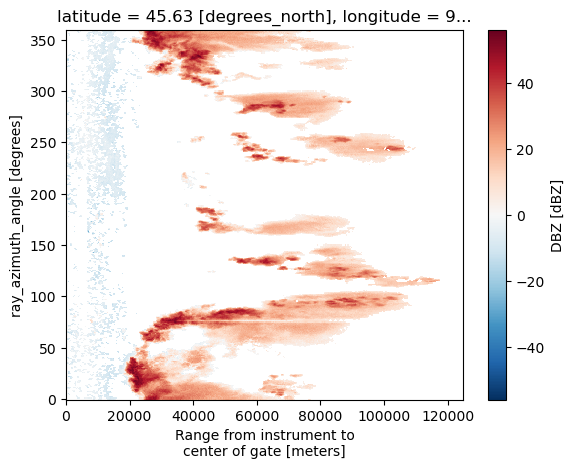

In [985]:
radar["sweep_3"].DBZ.plot()

In [966]:
subset = radar.combined_sweeps
subset

<xarray.Dataset> Size: 123MB
Dimensions:                    (gates: 1800, range: 416)
Coordinates:
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * gates                      (gates) object 14kB MultiIndex
  * sweep_number               (gates) float64 14kB 0.0 0.0 0.0 ... 4.0 4.0 4.0
  * azimuth                    (gates) float32 7kB 0.01923 1.027 ... 358.0 359.0
    time                       (gates, range) datetime64[ns] 6MB 2024-05-22T1...
    elevation                  (gates) float32 7kB 0.7031 0.7031 ... 6.979 6.982
    latitude                   float64 8B 45.63
    longitude                  float64 8B 9.196
    altitude                   float64 8B 241.0
Data variables: (12/30)
    sweep_fixed_angle          (gates, range) float32 3MB 0.7 0.7 ... 7.0 7.0
    sweep_mode                 (gates, range) object 6MB 'azimuth_surveillanc...
    prt_mode                   (gates, range) object 6MB b'fixed' ... b'fixed'
    follow_mode                (gates, range) object 6MB b'none' ... b'none'
    ray_n_gates                (gates, range) float64 6MB 416.0 416.0 ... 416.0
    ray_start_index            (gates, range) float64 6MB 5.824e+04 ... 6.103...
    ...                         ...
    DBZ                        (gates, range) float32 3MB nan nan ... nan nan
    MCSSX                      (gates, range) float32 3MB nan nan ... nan nan
    ZDR                        (gates, range) float32 3MB nan -3.19 ... nan nan
    KDP                        (gates, range) float32 3MB nan 0.0 ... nan nan
    WIDTH                      (gates, range) float32 3MB nan nan ... nan nan
    ngates                     (gates) int64 14kB 0 1 2 3 ... 1797 1798 1799

In [967]:
radar.combined_sweeps.sel(sweep_number=2)

<xarray.Dataset> Size: 25MB
Dimensions:                    (azimuth: 360, range: 416)
Coordinates:
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * azimuth                    (azimuth) float32 1kB 0.05219 1.005 ... 359.0
    time                       (azimuth, range) datetime64[ns] 1MB 2024-05-22...
    elevation                  (azimuth) float32 1kB 2.999 2.999 ... 2.999 2.999
    latitude                   float64 8B 45.63
    longitude                  float64 8B 9.196
    altitude                   float64 8B 241.0
    sweep_number               float64 8B 2.0
Data variables: (12/30)
    sweep_fixed_angle          (azimuth, range) float32 599kB 3.0 3.0 ... 3.0
    sweep_mode                 (azimuth, range) object 1MB 'azimuth_surveilla...
    prt_mode                   (azimuth, range) object 1MB b'fixed' ... b'fixed'
    follow_mode                (azimuth, range) object 1MB b'none' ... b'none'
    ray_n_gates                (azimuth, range) float64 1MB 416.0 ... 416.0
    ray_start_index            (azimuth, range) float64 1MB 3.424e+05 ... 3.4...
    ...                         ...
    DBZ                        (azimuth, range) float32 599kB nan nan ... nan
    MCSSX                      (azimuth, range) float32 599kB nan 1.0 ... nan
    ZDR                        (azimuth, range) float32 599kB nan 0.63 ... nan
    KDP                        (azimuth, range) float32 599kB nan 0.0 ... nan
    WIDTH                      (azimuth, range) float32 599kB nan nan ... nan
    ngates                     (azimuth) int64 3kB 720 721 722 ... 1078 1079

In [968]:
def generate_title(radar, field, sweep, datetime_format=None, use_sweep_time=True):
    """
    Generate a title for a plot.

    Parameters
    ----------
    radar : Radar
        Radar structure.
    field : str
        Field plotted.
    sweep : int
        Sweep plotted.
    datetime_format : str
        Format of datetime (using strftime format).
    use_sweep_time : bool
        If true, the current sweep's beginning time is used.

    Returns
    -------
    title : str
        Plot title.

    """
    if use_sweep_time:
        begin_time = pyart.graph.generate_radar_time_sweep(radar, sweep)
    else:
        begin_time = pyart.graph.generate_radar_time_begin(radar)
    if datetime_format:
        time_str = begin_time.strftime(datetime_format)
    else:
        time_str = begin_time.isoformat() + "Z"
    fixed_angle = radar.fixed_angle["data"][sweep]
    l1 = f"{pyart.graph.generate_radar_name(radar)} {fixed_angle:.1f} Deg. {time_str} "
    field_name = generate_field_name(radar, field)
    return l1 + "\n" + field_name

In [986]:
radar["sweep_0"].ds.xradar.georeference()

<xarray.Dataset> Size: 11MB
Dimensions:                    (azimuth: 360, range: 416)
Coordinates:
    time                       (azimuth, range) datetime64[ns] 1MB 2024-05-22...
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * azimuth                    (azimuth) float32 1kB 0.01923 1.027 ... 359.1
    elevation                  (azimuth) float32 1kB 0.7031 0.7031 ... 0.7031
    latitude                   float64 8B 45.63
    longitude                  float64 8B 9.196
    altitude                   float64 8B 241.0
    crs_wkt                    int64 8B 0
    x                          (azimuth, range) float64 1MB 0.05033 ... -2.04...
    y                          (azimuth, range) float64 1MB 150.0 ... 1.246e+05
    z                          (azimuth, range) float64 1MB 242.8 ... 2.685e+03
Data variables: (12/30)
    sweep_fixed_angle          float32 4B ...
    sweep_number               float64 8B ...
    sweep_mode                 <U20 80B 'azimuth_surveillance'
    prt_mode                   |S32 32B ...
    follow_mode                |S32 32B ...
    ray_n_gates                (azimuth) float64 3kB ...
    ...                         ...
    RHOHV                      (azimuth, range) float32 599kB nan 0.328 ... nan
    DBZ                        (azimuth, range) float32 599kB nan nan ... nan
    MCSSX                      (azimuth, range) float32 599kB nan nan ... nan
    ZDR                        (azimuth, range) float32 599kB nan -3.19 ... nan
    KDP                        (azimuth, range) float32 599kB nan 0.0 ... nan
    WIDTH                      (azimuth, range) float32 599kB nan nan ... nan

In [970]:
radar = Xradar(dt)

/Users/mgrover/mambaforge/envs/pyart-dev/lib/python3.12/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension sweep_number because variable sweep_number is not a coordinate. To create an index for sweep_number, please first call `.set_coords('sweep_number')` on this object.
  warnings.warn(


In [971]:
dt = dt.xradar.georeference()

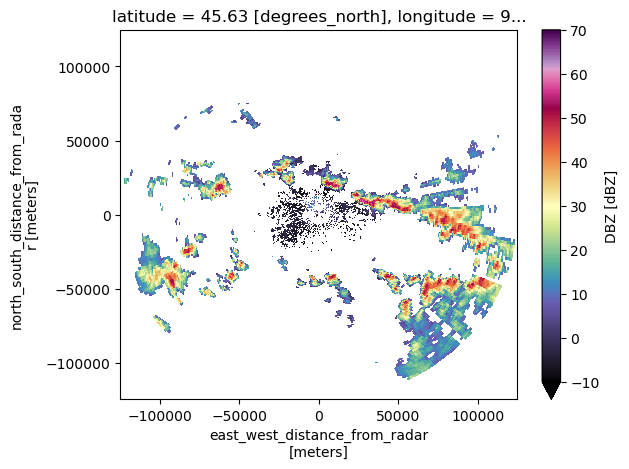

In [974]:
radar["sweep_0"]["DBZ"].plot(x="x", y="y", cmap="ChaseSpectral", vmin=-10, vmax=70)


/Users/mgrover/mambaforge/envs/pyart-dev/lib/python3.12/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension sweep_number because variable sweep_number is not a coordinate. To create an index for sweep_number, please first call `.set_coords('sweep_number')` on this object.
  warnings.warn(
/Users/mgrover/git_repos/pyart/pyart/graph/radardisplay.py:365: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pm = ax.pcolormesh(


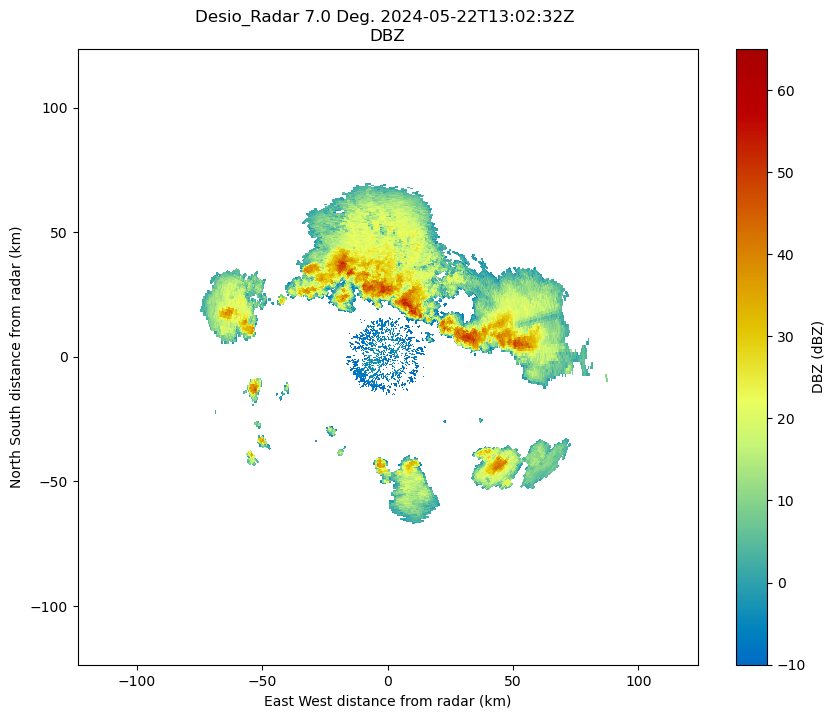

In [987]:
radar = Xradar(dt)
fig = plt.figure(figsize=[10, 8])
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi("DBZ", sweep=4)

In [779]:
dbz_pyart = pyart_radar.get_field(1, "DBZ")
x_pyart, y_pyart, z_pyart = pyart_radar.get_gate_x_y_z(1)

In [780]:
dbz_xradar = radar.get_field(1, "DBZ")
x_xradar, y_xradar, z_xradar = radar.get_gate_x_y_z(1)

[[ 5.03285147e-02  1.50985479e-01  2.51642355e-01 ...  4.16112702e+01
   4.17118693e+01  4.18124682e+01]
 [ 2.68883664e+00  8.06650642e+00  1.34441715e+01 ...  2.22311166e+03
   2.22848624e+03  2.23386081e+03]
 [ 5.41991983e+00  1.62597524e+01  2.70995756e+01 ...  4.48115248e+03
   4.49198609e+03  4.50281967e+03]
 ...
 [-7.80458394e+00 -2.34137417e+01 -3.90228858e+01 ... -6.45277638e+03
  -6.46837657e+03 -6.48397673e+03]
 [-5.14691050e+00 -1.54407248e+01 -2.57345301e+01 ... -4.25543024e+03
  -4.26571813e+03 -4.27600601e+03]
 [-2.45880049e+00 -7.37639826e+00 -1.22939917e+01 ... -2.03291935e+03
  -2.03783412e+03 -2.04274888e+03]]


In [781]:
radar.combined_sweeps

<xarray.Dataset> Size: 245MB
Dimensions:                    (sweep_number: 5, gates: 2880, range: 416)
Coordinates: (12/16)
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * gates                      (gates) object 23kB MultiIndex
  * sweep_number               (gates) float64 23kB 0.0 0.0 0.0 ... 7.0 7.0 7.0
  * azimuth                    (gates) float32 12kB 0.01923 1.027 ... 359.1
    time                       (gates, range) datetime64[ns] 10MB 2024-05-22T...
    elevation                  (gates) float32 12kB 0.7031 0.7031 ... 0.7031
    ...                         ...
    y                          (gates, range) float64 10MB 150.0 ... 1.246e+05
    z                          (gates, range) float64 10MB 242.8 ... 2.685e+03
    gr                         (gates, range) float64 10MB 0.001349 ... 1.121
    rays                       (gates, range) float32 5MB 0.01923 ... 359.1
    bins                       (gates, range) float32 5MB 150.0 ... 1.246e+05
    crs_wkt                    int64 8B 0
Data variables: (12/31)
    sweep_fixed_angle          (sweep_number) float32 20B 0.7 1.3 3.0 5.0 7.0
    sweep_mode                 (gates, range) object 10MB 'azimuth_surveillan...
    prt_mode                   (gates, range) object 10MB b'fixed' ... b'fixed'
    follow_mode                (gates, range) object 10MB b'none' ... b'none'
    ray_n_gates                (gates, range) float64 10MB 416.0 416.0 ... nan
    ray_start_index            (gates, range) float64 10MB 5.824e+04 ... nan
    ...                         ...
    MCSSX                      (gates, range) float32 5MB nan nan ... nan nan
    ZDR                        (gates, range) float32 5MB nan -3.19 ... nan nan
    KDP                        (gates, range) float32 5MB nan 0.0 ... nan nan
    WIDTH                      (gates, range) float32 5MB nan nan ... nan nan
    corrected_velocity         (gates, range) float32 5MB nan nan ... nan nan
    ngates                     (gates) int64 23kB 0 1 2 3 ... 2877 2878 2879

In [782]:
xd.__version__

'0.6.3'

/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_15741/1998001039.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_pyart, y_pyart, dbz_pyart)


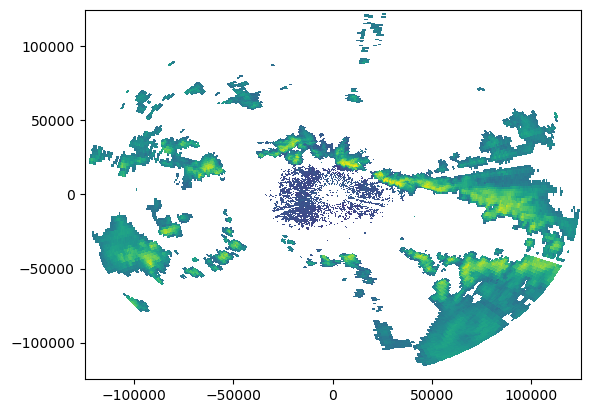

In [783]:
plt.pcolormesh(x_pyart, y_pyart, dbz_pyart)

In [787]:
dbz_pyart.shape

(360, 416)

In [786]:
dbz_xradar.shape

(360, 416)

/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_15741/1635835471.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_xradar, y_xradar, dbz_xradar)


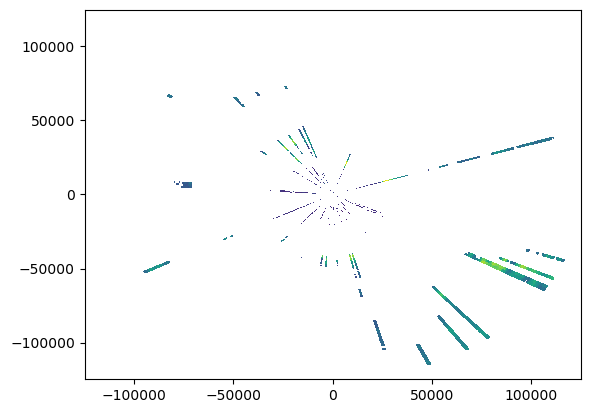

In [784]:
plt.pcolormesh(x_xradar, y_xradar, dbz_xradar)

/Users/mgrover/git_repos/pyart/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(
/Users/mgrover/mambaforge/envs/pyart-dev/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


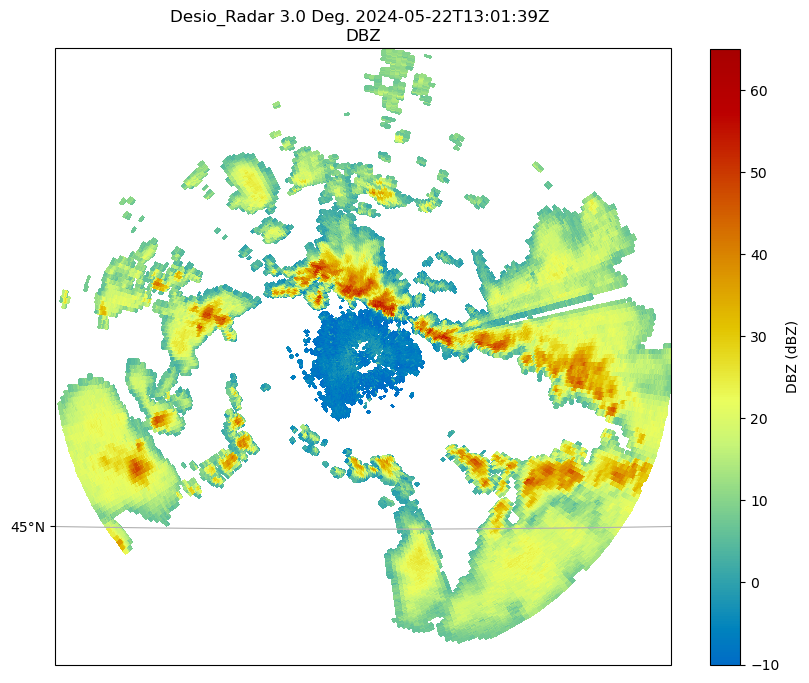

In [625]:
radar = Xradar(dt)
fig = plt.figure(figsize=[10, 8])
display = pyart.graph.RadarMapDisplay(pyart_radar)
display.plot_ppi_map("DBZ", sweep=2)

In [16]:
del display

### Wradlib

`Wradlib` functionality can also be applied to `Xarray.Datatree` objects. For example, the [`wradlib.georef`](https://docs.wradlib.org/en/latest/georef.html) module can be used to enrich data by adding geographical coordinates.

In [472]:
for key in list(dt.children):
    if "sweep" in key:
        dt[key].ds = dt[key].ds.wrl.georef.georeference(
            crs=wrl.georef.get_default_projection()
        )

In [473]:
dt["sweep_0"].ds.reflectivity.sel(range=slice(0, 5e4)).plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

AttributeError: 'DatasetView' object has no attribute 'reflectivity'

## Xradar exporters

In xradar, exporters convert radar data into various formats for analysis or integration. Exporting is supported for recognized standards, including:

- CfRadial1
- CfRadial2
- ODIM
- Zarr

Although [`Zarr`](https://zarr.readthedocs.io/en/stable/getting_started.html) is not a traditional standard format, it provides an analysis-ready, cloud-optimized format that enhances data accessibility and performance. 

In [19]:
dt.to_zarr("tree.zarr", consolidated=True, mode="w")

ModuleNotFoundError: No module named 'zarr'

In [ ]:
dt_back = open_datatree("tree.zarr", engine="zarr", chunks={})

In [ ]:
display(dt_back)

---

## Summary

`Xradar` is a Python library designed for working with radar data. It extends xarray to include radar-specific functionality, such as purpose-based accessors and georeferencing methods. It supports exporting data in various formats, including CfRadial1, CfRadial2, ODIM, and Zarr. xradar facilitates the analysis, visualization, and integration of radar data with other tools and systems.

## Resources and references
 - [Xradar](https://docs.openradarscience.org/projects/xradar/en/stable/index.html)
 - [Radar cookbook](https://github.com/ProjectPythia/radar-cookbook)
 - [Py-Art landing page](https://arm-doe.github.io/pyart/)
 - [Wradlib landing page](https://docs.wradlib.org/en/latest/index.html)
